# RSCV Model building

### Import Modules

In [1]:
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.stats import randint

In [2]:
print(np.__version__)

1.26.4


In [3]:
import sklearn

sklearn.show_versions()


System:
    python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.4.2
          pip: 24.0
   setuptools: 69.5.1
        numpy: 1.26.4
        scipy: 1.13.0
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


### Define Paths

In [4]:
# sys.path.clear()

# Basepath
basepath = "../"  # Project directory
sys.path.append(basepath)

# Data
DATA_PATH = basepath + "data"

# Results path
RESULTS_PATH = basepath + "03_Modelling/03_1_rscv/rscv_results/"

# Figure path
FIGURE_PATH = basepath + "03_Modelling/03_1_rscv/rscv_figures/"

# Path to environment
ENV_PATH = "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib"

# Modelpath
MODEL_PATH = basepath + "models"

# Logging
LOG_DIR = basepath + "03_Modelling/03_1_rscv/"

# Active Learning library
AL_PATH = basepath + "al_lib"

# Add the paths
sys.path.extend(
    {DATA_PATH, FIGURE_PATH, ENV_PATH, MODEL_PATH, RESULTS_PATH, LOG_DIR, AL_PATH}
)
sys.path  # Check if the path is correct

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 '../models',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../data',
 '../03_Modelling/03_1_rscv/',
 '../03_Modelling/03_1_rscv/rscv_results/',
 '../03_Modelling/03_1_rscv/rscv_figures/',
 '../al_lib']

### Logging

In [5]:
LOG_DIR

'../03_Modelling/03_1_rscv/'

In [6]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Define the notebook name and the output name
notebook_name = "03_1_rscv.ipynb"  # Is also used when saving the notebook
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Specify logging location
log_file_name = f"{notebook_name.split('.')[0]}_{date}.log"
log_file_dir = f"{LOG_DIR}"
log_file_path = f"{LOG_DIR}/{log_file_name}"
# print(f"Log file path: {log_file_path}")

# Get the logger
# logger = None
logging = create_logger(__name__, log_file_path=log_file_path)

# Usage of the logger as follows:
logging.info("Logging started")

2024-06-17 18:35:20 - INFO - Logging started


### Import Data

#### Import PS20191107_2deriv_gegl.csv

In [7]:
# Import 2nd_deriv

data_2nd_deriv_raw = pd.read_csv(
    DATA_PATH + "/PS20191107_2deriv_gegl.csv",
    on_bad_lines="skip",
    sep=";",
    decimal=",",
    encoding="utf-8",
)

data_2nd_deriv = data_2nd_deriv_raw.rename(columns={"Unnamed: 0": "Name"})

# Convert all columns of type 'object' to 'float' or 'int' if possible
for column in data_2nd_deriv.columns:
    # change datatype from the 'year' column to 'int
    if column == "year":
        data_2nd_deriv[column] = data_2nd_deriv[column].astype("int")
        print(f"'{column}' has been converted to 'int'.")
        # skip the rest of the loop
        continue
    try:
        data_2nd_deriv[column] = data_2nd_deriv[column].astype("float")
        # data_small.select_dtypes(include=['object']).astype('float')
    except ValueError:
        print(f"'{column}' could not be converted. Continue with other column(s).")
    except TypeError:
        print(f"'{column}' could not be converted. Continue with other column(s).")

'Name' could not be converted. Continue with other column(s).
'year' has been converted to 'int'.
'Origin' could not be converted. Continue with other column(s).
'type' could not be converted. Continue with other column(s).


In [8]:
data_2nd_deriv_raw.shape  # for quality control purposes

(2244, 1870)

In [9]:
data_2nd_deriv.shape

(2244, 1870)

## Select Data

In [10]:
# Switch for the dataset
# Select from (data_small, data_full, data_2nd_deriv) or other if implemented
data_raw = data_2nd_deriv
data_raw.dataset_name = "data_2nd_deriv"
logging.info(f"Dataset: {data_raw.dataset_name}")
logging.info(f"Size of the dataset: {data_raw.shape}")

2024-06-17 18:35:22 - INFO - Dataset: data_2nd_deriv
2024-06-17 18:35:22 - INFO - Size of the dataset: (2244, 1870)


## Modelling Parameters

In [11]:
# Define the parameters for the CV

# Switch for testing mode (use only 10% of the data, among others)
testing = False

# Define a random state for randomized processes
random_state = np.random.RandomState(202375)

if testing == True:
    nfolds = 3
    NoTrials = 5
    n_jobs = 20
    save_model = False
    data = data_raw.sample(frac=0.15, random_state=random_state)
    logging.info(f"Size of the dataset reduced: {data.shape}")
else:
    nfolds = 10
    NoTrials = 15
    n_jobs = 30
    save_model = True
    data = data_raw
    logging.info(f"Size of the dataset not reduced: {data.shape}")

# Log the modelling parameters
logging.info(
    f"Testing for Cross Validation: {testing}, nfolds: {nfolds}, NoTrials: {NoTrials}, n_jobs: {n_jobs}"
)


2024-06-17 18:35:22 - INFO - Size of the dataset not reduced: (2244, 1870)
2024-06-17 18:35:22 - INFO - Testing for Cross Validation: False, nfolds: 10, NoTrials: 15, n_jobs: 30


## Preprocessing

To apply the models we need to split the data into the variables and target.

In [12]:
data.dtypes

Name       object
year        int64
Origin     object
type       object
3996      float64
           ...   
407       float64
405       float64
403       float64
401       float64
399       float64
Length: 1870, dtype: object

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Columns: 1870 entries, Name to 399
dtypes: float64(1866), int64(1), object(3)
memory usage: 32.0+ MB


In [14]:
data.describe()

,year,3996,3994,3992,3990,3988,3987,3985,3983,3981,...,417,415,413,411,409,407,405,403,401,399
count,2244.000000,2244.0,2244.0,2244.0,2244.0,2244.0,2244.0,2244.000000,2244.000000,2244.000000,...,2244.000000,2244.000000,2.244000e+03,2244.000000,2244.0,2244.0,2244.0,2244.0,2244.0,2244.0
mean,-152.291889,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,-0.000002,-0.000005,...,-0.000006,-0.000003,9.369062e-07,0.000005,0.0,0.0,0.0,0.0,0.0,0.0
std,3659.189806,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000015,0.000015,...,0.000018,0.000017,1.806985e-05,0.000020,0.0,0.0,0.0,0.0,0.0,0.0
min,-13555.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000090,-0.000085,-0.000096,...,-0.000067,-0.000067,-9.610000e-05,-0.000125,0.0,0.0,0.0,0.0,0.0,0.0
25%,-370.250000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000008,-0.000012,-0.000014,...,-0.000018,-0.000015,-1.002500e-05,-0.000008,0.0,0.0,0.0,0.0,0.0,0.0
50%,1472.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,-0.000002,-0.000005,...,-0.000007,-0.000003,1.090000e-06,0.000005,0.0,0.0,0.0,0.0,0.0,0.0
75%,1806.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000011,0.000007,0.000004,...,0.000004,0.000008,1.300000e-05,0.000018,0.0,0.0,0.0,0.0,0.0,0.0
max,2009.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000073,0.000061,0.000077,...,0.000125,0.000133,1.100000e-04,0.000073,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Split into target and features
# The goal is to predict the year column of the dataset using the spectral data
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((2244, 1866), (2244,))

In [16]:
# count the number of columns with std = 0.0 in X
logging.info(f"Number of columns dropped, where std = 0.0 in X: {(X.std() == 0.0).sum()}")

2024-06-17 18:35:25 - INFO - Number of columns dropped, where std = 0.0 in X: 12


In [17]:
# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
X.shape, y.shape
logging.info(f"Dimensions of X after dropping columns with std = 0.0: {X.shape}")
logging.info(f"Dimensions of Y: {y.shape}")


2024-06-17 18:35:25 - INFO - Dimensions of X after dropping columns with std = 0.0: (2244, 1854)
2024-06-17 18:35:25 - INFO - Dimensions of Y: (2244,)


In [18]:
# Split the data into training and test sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
logging.info(f"random split with testsize {test_size} into training and test sets")


2024-06-17 18:35:25 - INFO - random split with testsize 0.3 into training and test sets


In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# assert the shapes and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

## Define Score metrics

In [20]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# create a scorer which calculates Root Mean Squeared Error (RMSE)

scoring = make_scorer(root_mean_squared_error, greater_is_better=False)
# scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
logging.info(f"Scorer: {scoring}")

2024-06-17 18:35:26 - INFO - Scorer: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')


# Modeling with Randomized Search Crossvalidation (RSCV)

#### Models

In [21]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.neural_network import MLPRegressor as MLP
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.ensemble import RandomForestRegressor

## Hyperparameter Definition

Randomized Search CV is usefull for the efficient exploration of a large parameter space. The results can consequently be used to design a fine grid for the Grid Search CV

In [22]:
# load the Hyperparameter distributions for the RandomizedSearchCV
from al_lib.rscv_parameters import (
    rf_rscv_parameters,
    pls_rscv_parameters,
    krr_rscv_parameters,
    mlp_rscv_parameters,
    xgb_rscv_parameters,
    hgb_rscv_parameters,
)

# to update the import without restarting the kernel, uncoment and modify the following line
# del <model>_parameters

In [23]:
import pandas as pd
import numpy as np

models = {
    "rf": RandomForestRegressor(),
    "pls": PLSRegression(),
    "krr": KRR(),
    "mlp": MLP(),
    "xgb": XGBRegressor(),
    "hgb": HGB(),
}

# Prepare objects to store the results
# Template:
# rf_rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])
for model in models.keys():
    globals()[f"{model}_rscv_results"] = pd.DataFrame(
        columns=["model", "MAE", "RMSE", "params"]
    )
    print(f"{model}_rscv_parameters")

rf_rscv_parameters
pls_rscv_parameters
krr_rscv_parameters
mlp_rscv_parameters
xgb_rscv_parameters
hgb_rscv_parameters


In [24]:
from al_lib.helper_functions import rmse_func as rmse
from al_lib.helper_functions import report_model
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import (
    mean_squared_error,
)  # also imports the neg_root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer


# create a scorer which calculates Root Mean Squeared Error (RMSE)


def rscv(
    features,
    target,
    model,
    param_distributions,
    results_file,
    random_state,
    NoTrials=5,
    nfolds=4,
    n_jobs=5,
    scoring=scoring, #
):
    """_summary_

    Args:
        features (_type_): _description_
        target (_type_): _description_
        model (_type_): _description_
        param_distributions (_type_): _description_
        results_file (_type_): _description_
        random_state (_type_): _description_
        NoTrials (int, optional): _description_. Defaults to 5.
        nfolds (int, optional): _description_. Defaults to 4.
        n_jobs (int, optional): _description_. Defaults to 5.
        scoring (_type_, optional): _description_. Defaults to scoring.

    Returns:
        _type_: _description_
    """
    # log the args
    logging.info(
        f"Features: {features.shape}, Target: {target.shape}, Model: {model}, Param_distributions: {param_distributions}, Results File: {results_file} Random_state: {random_state}, NoTrials: {NoTrials}, nfolds: {nfolds}, n_jobs: {n_jobs}, Scoring: {scoring}"
    )

    # prepare the result object 1
    rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])

    # define the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state
    )
    # create the result objects 2
    rscv_rmse_inner = np.zeros(NoTrials)
    rscv_rmse_outer = np.zeros(NoTrials)

    for i in range(NoTrials):
        logging.info(f"Trial: {i} out of {NoTrials}")
        # split for nested cross-validation
        inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

        # non-nested parameter search and scoring
        rscv = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            cv=inner_cv,
            random_state=random_state,
            scoring=scoring,

            n_jobs=n_jobs,
        )

        # fit
        rscv.fit(X_train, y_train)
        # make predictions to later estimate the generalization error
        y_pred = cvp(rscv, X_test, y_test, cv=outer_cv, n_jobs=n_jobs)
        all_predictions = np.zeros((len(y_test), NoTrials))
        all_predictions[:, i] = y_pred
        # calculate the RMSE for the inner and outer CV
        rscv_rmse_inner[i] = rscv.best_score_

        # calculate the RMSE for the outer CV
        # rscv_rmse_outer[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_rmse_outer[i] = rmse(y_test, y_pred)
        # store the results
        rscv_results.loc[i, "model"] = rscv.estimator
        rscv_results.loc[i, "MAE"] = mean_absolute_error(y_test, y_pred)
        rscv_results.loc[i, "RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_results.at[i, "params"] = rscv.best_params_
        report_model(rscv)

    # write results into outputifle
    rscv_results.to_csv(results_file, index=False, mode="a")

    return rscv_results
    # the goal of the rscv is to find the optimal hyperparameters
    # for further investigation we want to store
    # the 10 best model parameters and their scores
    # both the inner and outer cv scores, as well as the score difference

# Random Forest Regressor - RSCV

In [25]:
rf = RandomForestRegressor()
rf_rscv_results_file = f"{RESULTS_PATH}rf_rscv_results.csv"
logging.info(f"Results file: {rf_rscv_results_file}")

rscv(
    features=X,
    target=y,
    model=rf,
    param_distributions=rf_rscv_parameters,
    results_file=rf_rscv_results_file,
    random_state=random_state,
)

2024-06-17 18:35:26 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv
2024-06-17 18:35:26 - INFO - Features: (2244, 1854), Target: (2244,), Model: RandomForestRegressor(), Param_distributions: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e57fef0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e57fec0>, 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb561f58e30>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e7424b0>}, Results File: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-17 18:35:26 - INFO - Trial: 0 out of 5
2024-06-17 18:35:39 - INFO - Trial: 1 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 16, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 63}
Best score for RandomForestRegressor: -1571.700894265237
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=16, max_features=7, min_samples_split=8,
                      n_estimators=63)


2024-06-17 18:35:51 - INFO - Trial: 2 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 14, 'max_features': 7, 'min_samples_split': 13, 'n_estimators': 95}
Best score for RandomForestRegressor: -1648.3478019135125
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=14, max_features=7, min_samples_split=13,
                      n_estimators=95)


2024-06-17 18:36:01 - INFO - Trial: 3 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 10, 'max_features': 5, 'min_samples_split': 12, 'n_estimators': 55}
Best score for RandomForestRegressor: -1838.8551702974828
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=10, max_features=5, min_samples_split=12,
                      n_estimators=55)


2024-06-17 18:36:13 - INFO - Trial: 4 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 12, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 58}
Best score for RandomForestRegressor: -1619.4824893929226
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=12, max_features=6, n_estimators=58)
Best hyperparameters for RandomForestRegressor: {'max_depth': 10, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 65}
Best score for RandomForestRegressor: -1705.894495945826
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=10, max_features=6, min_samples_split=5,
                      n_estimators=65)


,model,MAE,RMSE,params
0,RandomForestRegressor(),1363.532802,2013.903013,"{'max_depth': 16, 'max_features': 7, 'min_samp..."
1,RandomForestRegressor(),1473.25488,2160.052193,"{'max_depth': 14, 'max_features': 7, 'min_samp..."
2,RandomForestRegressor(),1312.563502,1951.699939,"{'max_depth': 10, 'max_features': 5, 'min_samp..."
3,RandomForestRegressor(),1338.665948,1953.388604,"{'max_depth': 12, 'max_features': 6, 'min_samp..."
4,RandomForestRegressor(),1318.186087,1942.241611,"{'max_depth': 10, 'max_features': 6, 'min_samp..."


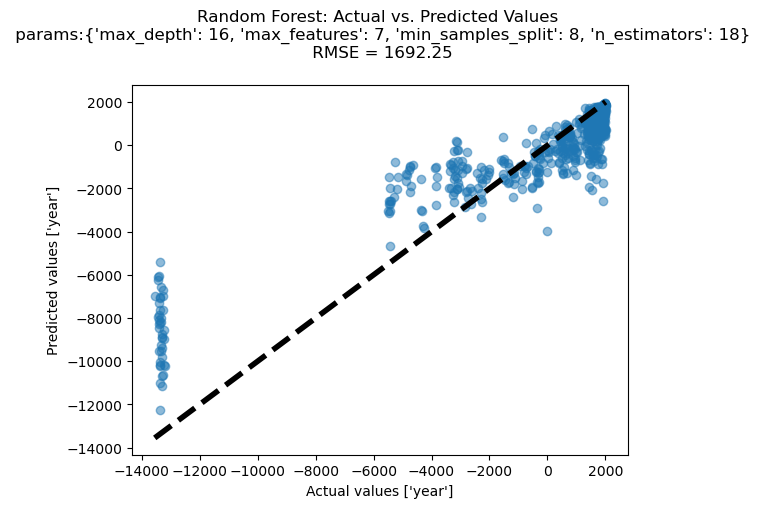

In [26]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
rf_results = pd.read_csv(rf_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_rf = rf_results.loc[rf_results["RMSE"].idxmin(), "params"]
optimal_params_rf = dict(eval(optimal_params_str_rf))

rf_opt = RandomForestRegressor(**optimal_params_rf)

y_pred_rf = rf_opt.fit(X_train, y_train).predict(X_test)

title_str = (
    f"Random Forest: Actual vs. Predicted Values \n params:"
    + optimal_params_str_rf
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_rf):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}avp_rf.png"
fig, ax = plt.subplots(1, 1)
rf_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_rf, param_dict, fig_path)

# PLS Regressor - RSCV


In [27]:
from sklearn import cross_decomposition

pls = cross_decomposition.PLSRegression()
pls_rscv_results_file = f"{RESULTS_PATH}/pls_rscv_results.csv"


rscv(
    features=X,
    target=y,
    model=pls,
    param_distributions=pls_rscv_parameters,
    results_file=pls_rscv_results_file,
    random_state=random_state,
)

2024-06-17 18:36:26 - INFO - Features: (2244, 1854), Target: (2244,), Model: PLSRegression(), Param_distributions: {'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e742840>, 'scale': [True, False], 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e742ab0>, 'tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb55e7427b0>, 'copy': [True]}, Results File: ../03_Modelling/03_1_rscv/rscv_results//pls_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-17 18:36:26 - INFO - Trial: 0 out of 5
2024-06-17 18:36:56 - INFO - Trial: 1 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 680, 'n_components': 39, 'scale': False, 'tol': 0.8435095727716886}
Best score for PLSRegression: -1426.542752300606
Best estimator for PLSRegression: PLSRegression(max_iter=680, n_components=39, scale=False,
              tol=0.8435095727716886)


2024-06-17 18:37:24 - INFO - Trial: 2 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 159, 'n_components': 32, 'scale': False, 'tol': 0.368084428049862}
Best score for PLSRegression: -1394.7024746369773
Best estimator for PLSRegression: PLSRegression(max_iter=159, n_components=32, scale=False, tol=0.368084428049862)


2024-06-17 18:37:51 - INFO - Trial: 3 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 179, 'n_components': 20, 'scale': True, 'tol': 0.8290495759442987}
Best score for PLSRegression: -1404.0747954466954
Best estimator for PLSRegression: PLSRegression(max_iter=179, n_components=20, tol=0.8290495759442987)


2024-06-17 18:38:22 - INFO - Trial: 4 out of 5


Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 152, 'n_components': 38, 'scale': False, 'tol': 0.32958613646158835}
Best score for PLSRegression: -1402.3649419435517
Best estimator for PLSRegression: PLSRegression(max_iter=152, n_components=38, scale=False,
              tol=0.32958613646158835)
Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 321, 'n_components': 45, 'scale': False, 'tol': 0.1558453412413154}
Best score for PLSRegression: -1463.8762030404669
Best estimator for PLSRegression: PLSRegression(max_iter=321, n_components=45, scale=False,
              tol=0.1558453412413154)


,model,MAE,RMSE,params
0,PLSRegression(),1373.262034,1884.915237,"{'copy': True, 'max_iter': 680, 'n_components'..."
1,PLSRegression(),1278.072827,1691.620891,"{'copy': True, 'max_iter': 159, 'n_components'..."
2,PLSRegression(),1197.91606,1640.345233,"{'copy': True, 'max_iter': 179, 'n_components'..."
3,PLSRegression(),1465.228114,1917.625017,"{'copy': True, 'max_iter': 152, 'n_components'..."
4,PLSRegression(),1202.385219,1618.641199,"{'copy': True, 'max_iter': 321, 'n_components'..."


In [28]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
pls_results = pd.read_csv(pls_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_pls = pls_results.loc[pls_results["RMSE"].idxmin(), "params"]
optimal_params_pls = dict(eval(optimal_params_str_pls))
# fit the data with the optimal model parameters
pls_opt = cross_decomposition.PLSRegression(**optimal_params_pls)

y_pred_pls = pls_opt.fit(X_train, y_train).predict(X_test)

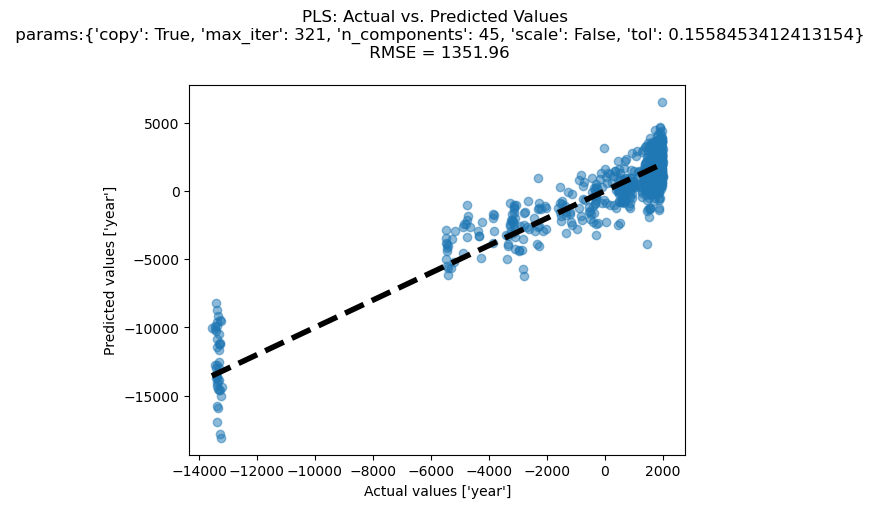

In [30]:
# plot
title_str = (
    f"PLS: Actual vs. Predicted Values \n params:"
    + optimal_params_str_pls
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_pls)):.2f}"
)

param_dict = {"title": title_str}
fig_path = (f"{FIGURE_PATH}/avp_pls.png")

fig, ax = plt.subplots(1, 1)
pls_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_pls, param_dict, fig_path)

# KKR Regressor - RSCV

In [31]:
from sklearn.kernel_ridge import KernelRidge as KRR

krr = KRR()
krr_rscv_results_file = f"{RESULTS_PATH}/krr_rscv_results.csv"

rscv(
    features=X,
    target=y,
    model=krr,
    param_distributions=krr_rscv_parameters,
    results_file=krr_rscv_results_file,
    random_state=random_state,
)

2024-06-17 18:43:43 - INFO - Features: (2244, 1854), Target: (2244,), Model: KernelRidge(), Param_distributions: {'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb55e56ef60>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb560650d70>, 'kernel': ['linear', 'poly', 'polynomial', 'rbf']}, Results File: ../03_Modelling/03_1_rscv/rscv_results//krr_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-17 18:43:43 - INFO - Trial: 0 out of 5
2024-06-17 18:43:47 - INFO - Trial: 1 out of 5


Best hyperparameters for KernelRidge: {'alpha': 0.0024655121351957344, 'gamma': 0.03581409238938134, 'kernel': 'rbf'}
Best score for KernelRidge: -3841.749061451649
Best estimator for KernelRidge: KernelRidge(alpha=0.0024655121351957344, gamma=0.03581409238938134,
            kernel='rbf')


2024-06-17 18:43:50 - INFO - Trial: 2 out of 5


Best hyperparameters for KernelRidge: {'alpha': 0.013558057755143849, 'gamma': 0.05787715945579274, 'kernel': 'polynomial'}
Best score for KernelRidge: -3844.5074448310147
Best estimator for KernelRidge: KernelRidge(alpha=0.013558057755143849, gamma=0.05787715945579274,
            kernel='polynomial')


2024-06-17 18:43:54 - INFO - Trial: 3 out of 5


Best hyperparameters for KernelRidge: {'alpha': 0.007839811983249779, 'gamma': 0.05416984165771427, 'kernel': 'rbf'}
Best score for KernelRidge: -3841.750393336517
Best estimator for KernelRidge: KernelRidge(alpha=0.007839811983249779, gamma=0.05416984165771427, kernel='rbf')


2024-06-17 18:43:57 - INFO - Trial: 4 out of 5


Best hyperparameters for KernelRidge: {'alpha': 0.059223181734324185, 'gamma': 0.08455815099828548, 'kernel': 'poly'}
Best score for KernelRidge: -3845.734949419114
Best estimator for KernelRidge: KernelRidge(alpha=0.059223181734324185, gamma=0.08455815099828548,
            kernel='poly')
Best hyperparameters for KernelRidge: {'alpha': 0.009556448753353253, 'gamma': 0.025740275992635134, 'kernel': 'linear'}
Best score for KernelRidge: -3824.013109314223
Best estimator for KernelRidge: KernelRidge(alpha=0.009556448753353253, gamma=0.025740275992635134)


,model,MAE,RMSE,params
0,KernelRidge(),2106.590292,3167.752271,"{'alpha': 0.0024655121351957344, 'gamma': 0.03..."
1,KernelRidge(),2118.179387,3173.220807,"{'alpha': 0.013558057755143849, 'gamma': 0.057..."
2,KernelRidge(),2138.843168,3163.119549,"{'alpha': 0.007839811983249779, 'gamma': 0.054..."
3,KernelRidge(),2128.956232,3161.041883,"{'alpha': 0.059223181734324185, 'gamma': 0.084..."
4,KernelRidge(),2108.46124,3169.658675,"{'alpha': 0.009556448753353253, 'gamma': 0.025..."


In [32]:
# generate the actual vs. predicted plot

# import the optimal model parameters
krr_results = pd.read_csv(krr_rscv_results_file)

# select the model parameters with the lowest RMSE
optimal_params_str_krr = krr_results.loc[krr_results["RMSE"].idxmin(), "params"]
optimal_params_krr = dict(eval(optimal_params_str_krr))
krr_opt = KRR(**optimal_params_krr)

y_pred_krr = krr_opt.fit(X_train, y_train).predict(X_test)

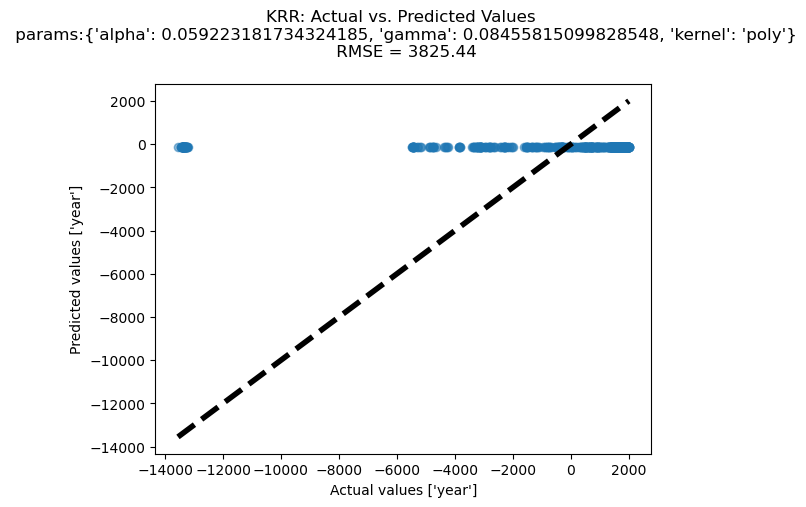

In [34]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_krr string into more lines

title_str = (
    f"KRR: Actual vs. Predicted Values \n params:"
    + optimal_params_str_krr
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_krr)):.2f}"
)

param_dict = {"title": title_str}
fig_path_krr = (f"{FIGURE_PATH}/avp_krr.png")

fig, ax = plt.subplots(1, 1)
krr_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_krr, param_dict, fig_path_krr)

# MLP Regressor - RSCV

In [36]:
# import mlp
from sklearn.neural_network import MLPRegressor as MLP

mlp = MLP()
mlp_rscv_results_file = f"{RESULTS_PATH}/mlp_rscv_results.csv"

rscv_mpl = rscv(
    features=X,
    target=y,
    model=mlp,
    param_distributions=mlp_rscv_parameters,
    results_file=mlp_rscv_results_file,
    random_state=random_state,
)

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': 0.02667565513908713, 'early_stopping': True, 'hidden_layer_sizes': 154, 'solver': 'lbfgs', 'validation_fraction': 0.10579126616982742}
Best score for MLPRegressor: -1973.511767220243
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=0.02667565513908713, early_stopping=True,
             hidden_layer_sizes=154, solver='lbfgs',
             validation_fraction=0.10579126616982742)


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sc

Best hyperparameters for MLPRegressor: {'activation': 'relu', 'alpha': 0.07018610271938198, 'early_stopping': True, 'hidden_layer_sizes': 69, 'solver': 'lbfgs', 'validation_fraction': 0.1081163889604213}
Best score for MLPRegressor: -2042.893223536774
Best estimator for MLPRegressor: MLPRegressor(alpha=0.07018610271938198, early_stopping=True,
             hidden_layer_sizes=69, solver='lbfgs',
             validation_fraction=0.1081163889604213)


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'relu', 'alpha': 0.022455499987710317, 'early_stopping': True, 'hidden_layer_sizes': 94, 'solver': 'lbfgs', 'validation_fraction': 0.12322241056298079}
Best score for MLPRegressor: -2028.884430774663
Best estimator for MLPRegressor: MLPRegressor(alpha=0.022455499987710317, early_stopping=True,
             hidden_layer_sizes=94, solver='lbfgs',
             validation_fraction=0.12322241056298079)


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': 0.039726375321650416, 'early_stopping': False, 'hidden_layer_sizes': 172, 'solver': 'lbfgs', 'validation_fraction': 0.11635606683567792}
Best score for MLPRegressor: -1976.1251211529334
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=0.039726375321650416,
             hidden_layer_sizes=172, solver='lbfgs',
             validation_fraction=0.11635606683567792)


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': 0.05255106933140498, 'early_stopping': False, 'hidden_layer_sizes': 58, 'solver': 'lbfgs', 'validation_fraction': 0.19595349950582952}
Best score for MLPRegressor: -2138.0971482844516
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=0.05255106933140498,
             hidden_layer_sizes=58, solver='lbfgs',
             validation_fraction=0.19595349950582952)


In [39]:
optimal_params_mlp

{'activation': 'tanh',
 'alpha': 0.02667565513908713,
 'early_stopping': True,
 'hidden_layer_sizes': 154,
 'solver': 'lbfgs',
 'validation_fraction': 0.10579126616982742}

In [40]:
# generate the actual vs. predicted plot

# import the optimal model parameters
mlp_results = pd.read_csv(mlp_rscv_results_file)

# select the (optimal) model parameters with the lowest RMSE
optimal_params_str_mlp = mlp_results.loc[mlp_results["RMSE"].idxmin(), "params"]
optimal_params_mlp = dict(eval(optimal_params_str_mlp))

# fit the data with the optimal model parameters
mlp_opt = MLP(**optimal_params_mlp)

y_pred_mlp = mlp_opt.fit(X_train, y_train).predict(X_test)

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


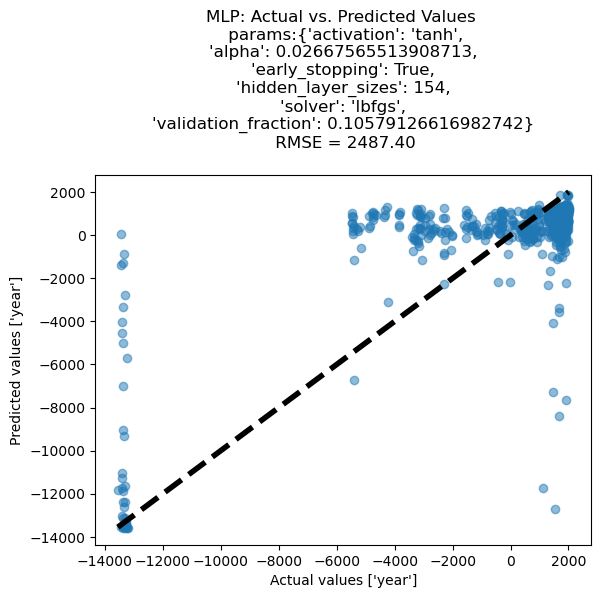

In [45]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_mlp string into more lines
optimal_params_str_mlp_break = optimal_params_str_mlp.replace(", ", ",\n")

title_str = (
    f"MLP: Actual vs. Predicted Values \n params:"
    + optimal_params_str_mlp_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_mlp)):.2f}"
)

param_dict = {"title": title_str}
fig_path_mlp = (f"{FIGURE_PATH}/avp_mlp.png")

fig, ax = plt.subplots(1, 1)
mlp_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_mlp, param_dict, fig_path_mlp)

In [46]:
# import xgboost
import xgboost as xgb
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb_rscv_results_file = f"{RESULTS_PATH}/xgb_rscv_results.csv"

rscv_xgb = rscv(
    features=X,
    target=y,
    model=xgb,
    param_distributions=xgb_rscv_parameters,
    results_file=xgb_rscv_results_file,
    random_state=random_state,
)

2024-06-17 19:37:33 - INFO - Features: (2244, 1854), Target: (2244,), Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), Param_distributions: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e7431d0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discr

Best hyperparameters for XGBRegressor: {'colsample_bytree': 0.8801118290789387, 'gamma': 0.048938279121365835, 'learning_rate': 0.059504066774269275, 'max_depth': 4, 'n_estimators': 88, 'reg_alpha': 0.3490074679649478, 'reg_lambda': 0.12584195707947787, 'subsample': 0.9831847591319467}
Best score for XGBRegressor: -989.9447631495739
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8801118290789387, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.048938279121365835,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.059504066774269275,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=No

2024-06-17 20:00:49 - INFO - Trial: 2 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': 0.5670902721775144, 'gamma': 0.472521034984004, 'learning_rate': 0.07068152945632575, 'max_depth': 5, 'n_estimators': 67, 'reg_alpha': 0.03346607958994746, 'reg_lambda': 0.38957685932451447, 'subsample': 0.5316196015781669}
Best score for XGBRegressor: -990.7275271821477
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5670902721775144, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.472521034984004,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07068152945632575,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, mis

2024-06-17 20:13:44 - INFO - Trial: 3 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': 0.8577901585022998, 'gamma': 0.09436006807752356, 'learning_rate': 0.041848657674063774, 'max_depth': 7, 'n_estimators': 88, 'reg_alpha': 0.125350580588786, 'reg_lambda': 0.22587822493001075, 'subsample': 0.8574728803692789}
Best score for XGBRegressor: -1091.6412452517927
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8577901585022998, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.09436006807752356,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041848657674063774,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None

2024-06-17 20:30:44 - INFO - Trial: 4 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': 0.7763839879877599, 'gamma': 0.15995857658465223, 'learning_rate': 0.0449484798169904, 'max_depth': 9, 'n_estimators': 89, 'reg_alpha': 0.14857916769121837, 'reg_lambda': 0.18692342424416425, 'subsample': 0.8676360619228729}
Best score for XGBRegressor: -1130.1298567911529
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7763839879877599, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.15995857658465223,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0449484798169904,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, 

In [47]:
# generate the actual vs. predicted plot

# import the optimal model parameters
xgb_results = pd.read_csv(xgb_rscv_results_file)

# round the results to 4 decimal places
xgb_results = xgb_results.round(4)

# select the model parameters with the lowest RMSE
optimal_params_str_xgb = xgb_results.loc[xgb_results["RMSE"].idxmin(), "params"]
optimal_params_xgb = dict(eval(optimal_params_str_xgb))

# fit the data with the optimal model parameters
xgb_opt = XGBRegressor(**optimal_params_xgb)

y_pred_xgb = xgb_opt.fit(X_train, y_train).predict(X_test)

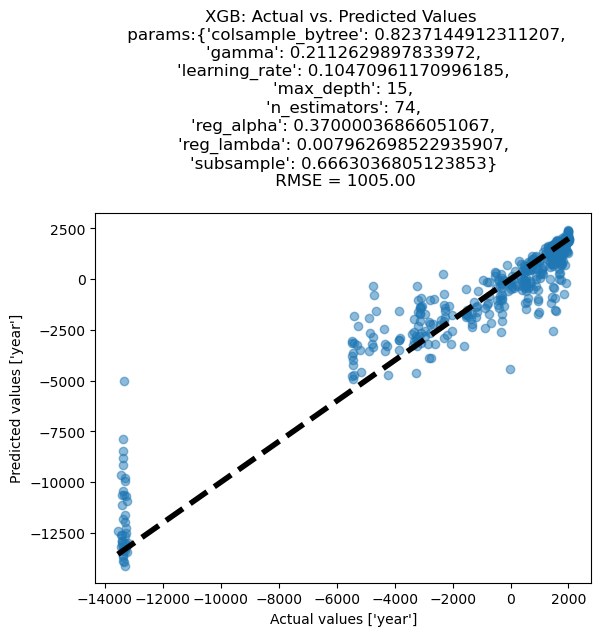

In [48]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_xgb_break = optimal_params_str_xgb.replace(", ", ",\n")


title_str = (
    f"XGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_xgb_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}"
)

param_dict = {"title": title_str}
fig_path = (f"{FIGURE_PATH}/avp_xgb.png")

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict)

# HGB

In [49]:
# HGB
from sklearn.ensemble import HistGradientBoostingRegressor as HGB

hbg = HGB()
hgb_rscv_results_file = f"{RESULTS_PATH}/hgb_rscv_results.csv"

rscv_hgb = rscv(
    features=X,
    target=y,
    model=hbg,
    param_distributions=hgb_rscv_parameters,
    results_file=hgb_rscv_results_file,
    random_state=random_state,
)

2024-06-17 20:51:15 - INFO - Features: (2244, 1854), Target: (2244,), Model: HistGradientBoostingRegressor(), Param_distributions: {'loss': ['squared_error'], 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb55e742450>, 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e742000>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e741640>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb55e741d00>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//hgb_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-17 20:51:15 - INFO - Trial: 0 out of 5
2024-06-17 21:03:59 - INFO - Trial: 1 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': 0.03737687002695101, 'loss': 'squared_error', 'max_iter': 391, 'max_leaf_nodes': 86, 'min_samples_leaf': 32}
Best score for HistGradientBoostingRegressor: -943.5007889699507
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=0.03737687002695101, max_iter=391,
                              max_leaf_nodes=86, min_samples_leaf=32)


2024-06-17 21:21:51 - INFO - Trial: 2 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': 0.026674675412324184, 'loss': 'squared_error', 'max_iter': 462, 'max_leaf_nodes': 82, 'min_samples_leaf': 16}
Best score for HistGradientBoostingRegressor: -933.5684396101088
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=0.026674675412324184, max_iter=462,
                              max_leaf_nodes=82, min_samples_leaf=16)


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-17 21:39:56 - INFO - Trial: 3 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': 0.0628802929193671, 'loss': 'squared_error', 'max_iter': 365, 'max_leaf_nodes': 76, 'min_samples_leaf': 37}
Best score for HistGradientBoostingRegressor: -1025.2209096321787
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=0.0628802929193671, max_iter=365,
                              max_leaf_nodes=76, min_samples_leaf=37)


In [ ]:
# generate the actual vs. predicted plot
hgb_results = pd.read_csv(hgb_rscv_results_file)

# select the model parameters with the lowest RMSE
# select the model parameters with the lowest RMSE
optimal_params_str_hgb = hgb_results.loc[hgb_results["RMSE"].idxmin(), "params"]
optimal_params_hgb = dict(eval(optimal_params_str_hgb))

# fit the data with the optimal model parameters
hgb_opt = HGB(**optimal_params_hgb)

y_pred_hgb = hgb_opt.fit(X_train, y_train).predict(X_test)

In [ ]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_hgb_break = optimal_params_str_hgb.replace(", ", ",\n")


title_str = (
    f"HGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_hgb_break
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_hgb):.2f}"
)
fig_path = (f"{FIGURE_PATH}/avp_xgb.png")
param_dict = {"title": title_str}

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict, fig_path)

# Quality Control

In this section the goal is to document the packages which where used during the execution of this notebook

In [ ]:
## Package informations
from sklearn import show_versions

show_versions()


System:
    python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.4.2
          pip: 24.0
   setuptools: 69.5.1
        numpy: 1.26.4
        scipy: 1.13.0
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


In [ ]:
import subprocess
import os
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Create the output name from the notebookname

output_name = f"{notebook_name.split('.')[0]}_{date}.html"


# Function to convert the notebook to HTML
def convert_notebook_to_html(notebook_name, output_name):
    # Use subprocess to call the jupyter nbconvert command
    subprocess.call(["jupyter", "nbconvert", "--to", "html", notebook_name])
    # Rename the output file
    os.rename(notebook_name.split(".")[0] + ".html", output_name)


# Wait for a short period to ensure all cells have finished executing
time.sleep(5)  # Adjust the sleep duration as needed

# Convert the notebook to HTML
convert_notebook_to_html(notebook_name, output_name)

[NbConvertApp] Converting notebook 03_3_modeling_slim.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 1049840 bytes to 03_3_modeling_slim.html
